# IMPORT  AND CLEAN DATA

In [552]:
# GENERAL
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import HTML
plt.style.use('fivethirtyeight')
%matplotlib inline

# SCALING
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# LINEAR REGRESSION
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
from sklearn.model_selection import train_test_split

# POLYNOMIALS
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# CLUSTERING
from sklearn.metrics import pairwise_distances
from sklearn import cluster, datasets, preprocessing, metrics
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_samples


In [553]:
# TWO DATA SETS: OBSERVATIONS AND REMAINDER OF DESIGN SPACE
data = pd.read_csv('./CSV/180702_output.csv')
data_pred = pd.read_csv('./CSV/full_design_space.csv')

In [554]:
data.drop(['img', 'img_pixelmap', 'img_thumb', 'pixelmap', 'threeD', 'name', 'score', 'out:GFA'], axis=1, inplace=True)

In [555]:
data.columns = ['dist', 'den_multi', 'green', 'grid', 'iteration', 'park_attr_str', 'park_attr',
               'street_width', 'bar_bldg', 'courtyard', 'extrusion', 'industrial', 'infill',
                'small_mid', 'towers', 'comfort', 'daylighting', 'energy', 'view', 'street_area', 'surprise']

data_pred.columns = ['iteration', 'grid', 'den_multi', 'dist', 'green', 'park_attr', 'street_width', 'park_attr_str']

In [556]:
# CREATE DUMMY VARIABLES FOR GRID, PARK_ATTR

grid_dummies = pd.get_dummies(data.grid, prefix='grid')
data = pd.concat([data, grid_dummies], axis=1)
data.drop('grid', axis=1, inplace=True)
park_dummies = pd.get_dummies(data.park_attr, prefix='park_attr')
data = pd.concat([data, park_dummies], axis=1)
data.drop('park_attr', axis=1, inplace=True)

grid_dummies2 = pd.get_dummies(data_pred.grid, prefix='grid')
data_pred = pd.concat([data_pred, grid_dummies2], axis=1)
data_pred.drop('grid', axis=1, inplace=True)
park_dummies2 = pd.get_dummies(data_pred.park_attr, prefix='park_attr')
data_pred = pd.concat([data_pred, park_dummies2], axis=1)
data_pred.drop('park_attr', axis=1, inplace=True)

# EDA

In [557]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8600 entries, 0 to 8599
Data columns (total 28 columns):
dist             8600 non-null float64
den_multi        8600 non-null float64
green            8600 non-null float64
iteration        8600 non-null int64
park_attr_str    8600 non-null float64
street_width     8600 non-null float64
bar_bldg         8600 non-null int64
courtyard        8600 non-null int64
extrusion        8600 non-null int64
industrial       8600 non-null int64
infill           8600 non-null int64
small_mid        8600 non-null int64
towers           8600 non-null int64
comfort          8600 non-null int64
daylighting      8600 non-null float64
energy           8600 non-null float64
view             8600 non-null int64
street_area      8600 non-null int64
surprise         8600 non-null float64
grid_0           8600 non-null uint8
grid_1           8600 non-null uint8
grid_2           8600 non-null uint8
grid_3           8600 non-null uint8
grid_4           8600 non-

In [558]:
cols = data.columns
for name in cols:
    uniques = len(data[name].unique())
    print(f'{name} has {uniques} unique values')

dist has 7 unique values
den_multi has 5 unique values
green has 5 unique values
iteration has 8600 unique values
park_attr_str has 4 unique values
street_width has 7 unique values
bar_bldg has 85 unique values
courtyard has 80 unique values
extrusion has 24 unique values
industrial has 4 unique values
infill has 463 unique values
small_mid has 23 unique values
towers has 56 unique values
comfort has 359 unique values
daylighting has 2448 unique values
energy has 1 unique values
view has 1002 unique values
street_area has 7405 unique values
surprise has 47 unique values
grid_0 has 2 unique values
grid_1 has 2 unique values
grid_2 has 2 unique values
grid_3 has 2 unique values
grid_4 has 2 unique values
grid_5 has 2 unique values
park_attr_0 has 2 unique values
park_attr_1 has 2 unique values
park_attr_2 has 2 unique values


In [559]:
# FIND TOP SCORES FOR EACH METRIC
view = round(data.view.sort_values(ascending=False).head().mean(), 2)
daylighting = round(data.daylighting.sort_values(ascending=False).head().mean(), 2)
energy = round(data.energy.sort_values().head().mean(), 2)
comfort = round(data.comfort.sort_values(ascending=False).head().mean(), 2)
surprise = round(data.surprise.sort_values(ascending=False).head().mean(), 2)

scores = {'view':view, 'daylighting':daylighting, 'energy':energy, 'comfort':comfort, 'surprise':surprise}
print(scores)

{'view': 1067.0, 'daylighting': 79.26, 'energy': 0.0, 'comfort': 595.6, 'surprise': 0.64}


C:\Users\jdanforth\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
C:\Users\jdanforth\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\jdanforth\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


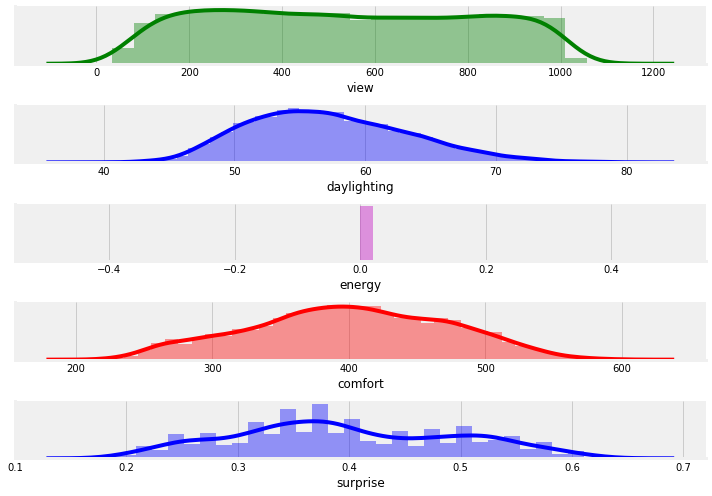

In [560]:
f, axes = plt.subplots(5, 1, figsize=(10, 7), sharex=False)
sns.despine()
sns.distplot(data["view"], color="g", ax=axes[0], axlabel="view")
sns.distplot(data["daylighting"], color="b", ax=axes[1], axlabel="daylighting")
sns.distplot(data["energy"], color="m", ax=axes[2], axlabel="energy")
sns.distplot(data["comfort"], color="r", ax=axes[3], axlabel="comfort")
sns.distplot(data["surprise"], color="b", ax=axes[4], axlabel="surprise")
plt.setp(axes, yticks=[])
plt.tight_layout()

In [561]:
# Why aren't surprise values smooth?

In [562]:
data.columns

Index(['dist', 'den_multi', 'green', 'iteration', 'park_attr_str',
       'street_width', 'bar_bldg', 'courtyard', 'extrusion', 'industrial',
       'infill', 'small_mid', 'towers', 'comfort', 'daylighting', 'energy',
       'view', 'street_area', 'surprise', 'grid_0', 'grid_1', 'grid_2',
       'grid_3', 'grid_4', 'grid_5', 'park_attr_0', 'park_attr_1',
       'park_attr_2'],
      dtype='object')

In [563]:
hmap_df = pd.concat([data['dist'], data['den_multi'], data['green'], data['park_attr_str'], data['street_width'],
                    data['grid_0'], data['grid_1'], data['grid_2'], data['grid_3'], data['grid_4'], data['grid_5'],
                    data['park_attr_0'], data['park_attr_1'], data['park_attr_2'], data['towers'], data['extrusion'], 
                    data['courtyard'], data['bar_bldg'], data['industrial'], data['small_mid'], data['infill'],
                    data['comfort'], data['view'], data['daylighting'], data['energy'], data['surprise']], axis=1, 
                    keys=['dist', 'den_multi', 'green', 'park_attr_str', 'street_width', 'grid_0', 'grid_1', 'grid_2',
                         'grid_3', 'grid_4', 'grid_5', 'park_attr_0', 'park_attr_1', 'park_attr_2', 'towers', 'extrusion',
                         'courtyard', 'bar_bldg', 'industrial', 'small_mid', 'infill', 'comfort', 'view', 'daylighting',
                         'energy', 'surprise'])

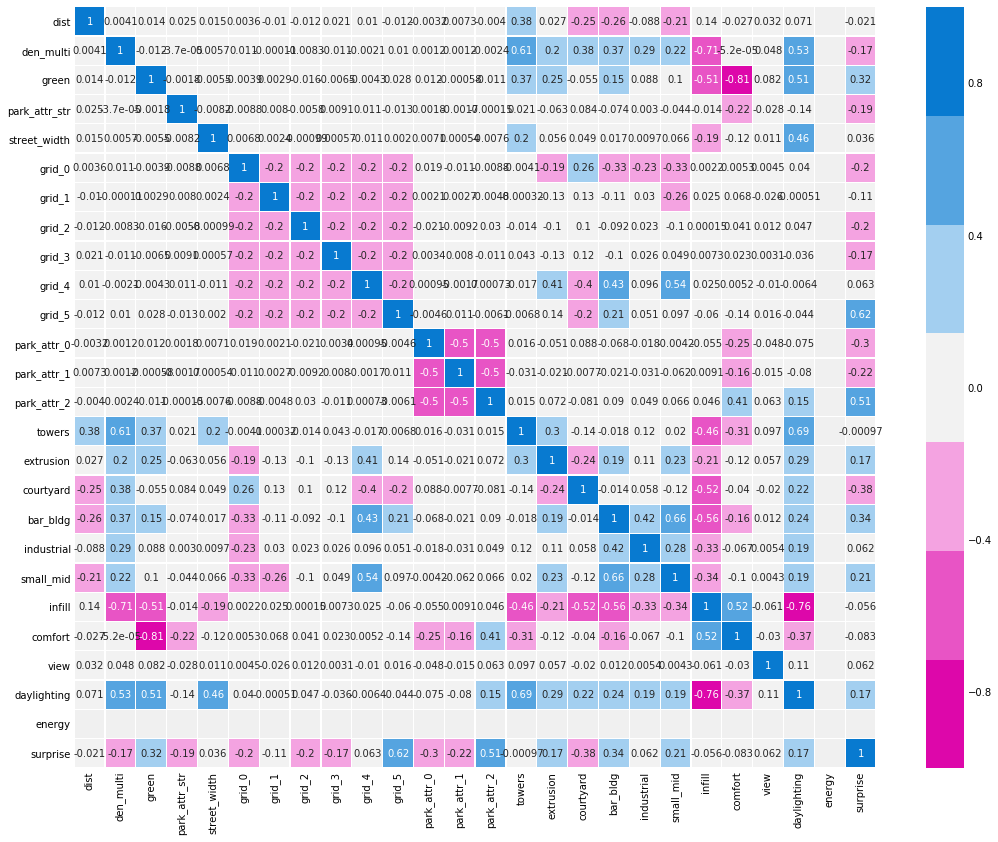

In [564]:
fig, ax = plt.subplots(figsize=(16,14))
color = sns.diverging_palette(330, 250, n=7, s=99)

heat = sns.heatmap(hmap_df.corr(), ax=ax, annot=True, vmin=-1, vmax=1, linewidths=0.25, cmap=color);

In [565]:
#heat.get_figure().savefig("heatmap.png", facecolor='white')
# Note extra .get_figure() method required for heatmap (type different than pairplot)

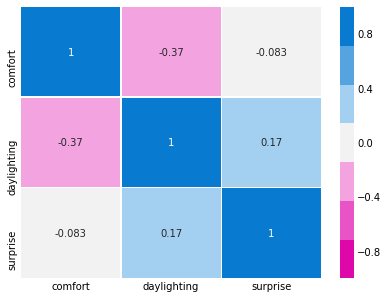

In [566]:
drop_cols = ['iteration', 'energy', 'view', 'park_attr_str', 'grid_0', 'grid_1', 'grid_2', 'grid_3', 
             'grid_4', 'grid_5', 'park_attr_0', 'park_attr_1', 'park_attr_2', 'dist', 'den_multi', 
            'green', 'street_width', 'bar_bldg', 'courtyard', 'extrusion', 'industrial', 'infill', 
            'small_mid', 'towers', 'street_area']
fig, ax = plt.subplots(figsize=(6,5))
color = sns.diverging_palette(330, 250, n=7, s=99)
#sns.set_style("white")

heat = sns.heatmap(data.drop(drop_cols, axis=1).corr(), ax=ax, annot=True, vmin=-1, vmax=1, linewidths=0.25, cmap=color);

In [567]:
#data[['comfort', 'surprise', 'daylighting']].corrwith(data[['park_attr_0', 'park_attr_1', 'park_attr_2']])
data['daylighting'].corr(data['park_attr_2'])

0.15450875895470745

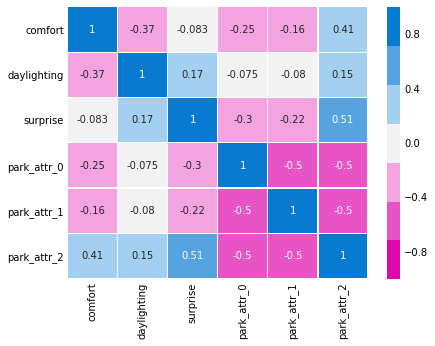

In [568]:
drop_cols = ['iteration', 'energy', 'view', 'park_attr_str', 'grid_0', 'grid_1', 'grid_2', 'grid_3', 
             'grid_4', 'grid_5', 'dist', 'den_multi', 
            'green', 'street_width', 'bar_bldg', 'courtyard', 'extrusion', 'industrial', 'infill', 
            'small_mid', 'towers', 'street_area']
fig, ax = plt.subplots(figsize=(6,5))
color = sns.diverging_palette(330, 250, n=7, s=99)
#sns.set_style("white")

heat_crop = sns.heatmap(data.drop(drop_cols, axis=1).corr(), ax=ax, annot=True, vmin=-1, vmax=1, linewidths=0.25, cmap=color);

In [569]:
heat_crop.get_figure().savefig("heatmap_crop.png", facecolor='white')

In [570]:
# if daylighting and surprise are correlated, I'd expect optimizing for top scores will privilege them
# and punish comfort. 

In [571]:
def box_plotter(out_put):
    global bplot
    
    corr = round(data[in_put].corr(data[out_put]), 3)
    scores = round(data.groupby(in_put)[out_put].mean(), 2)

    meanpointprops = dict(marker='D', markeredgecolor='black',markerfacecolor='firebrick')
    boxprops = dict(linestyle='-', linewidth=3, color='darkgoldenrod')

    bplot = data.boxplot(column=out_put, by=in_put, figsize=(6,6), notch=True, showmeans=True,
                meanprops=meanpointprops, boxprops=boxprops);

    plt.title('')
    plt.suptitle('')
    plt.ylabel(out_put)
    plt.figtext(1, 0.5,'Correlation between {} and {}: {}\n\nMean Values:\n\n{}'.format(in_put, out_put, corr, scores.to_string()), 
                wrap=True, horizontalalignment='left', fontsize=13, name='ARIAL');
    
    

## DENSITY

In [572]:
in_put = 'den_multi'

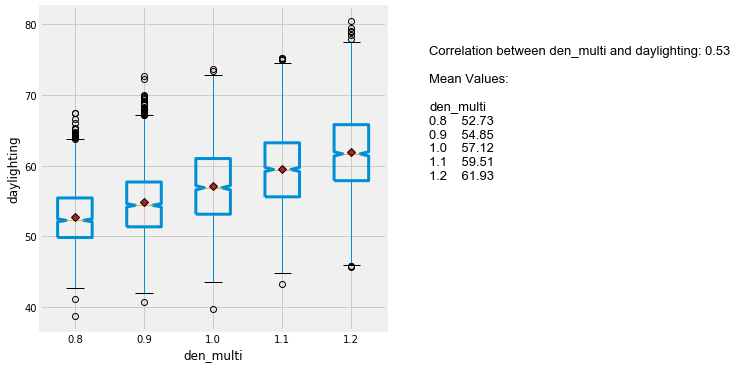

In [573]:
box_plotter('daylighting')

In [574]:
bplot.get_figure().savefig("daylight_den_multi.png", facecolor='white')

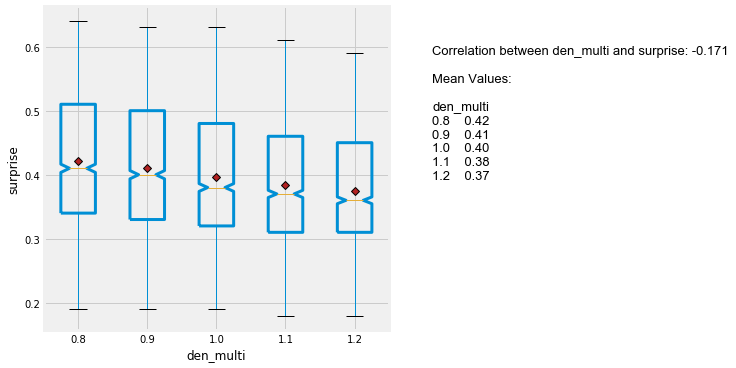

In [575]:
box_plotter('surprise')

In [576]:
bplot.get_figure().savefig("surprise_den_multi.png", facecolor='white')

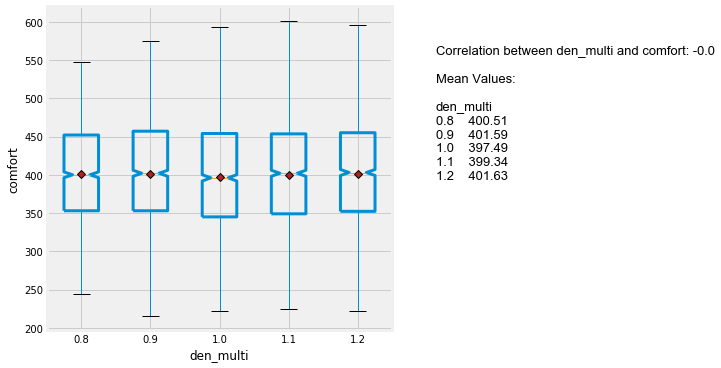

In [577]:
box_plotter('comfort')

In [578]:
bplot.get_figure().savefig("comfort_den_multi.png", facecolor='white')

## GREEN

In [579]:
in_put = 'green'

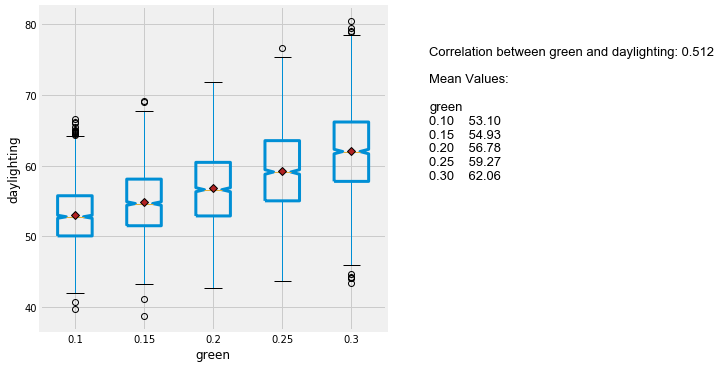

In [580]:
box_plotter('daylighting')

In [581]:
bplot.get_figure().savefig("daylight_green.png", facecolor='white')

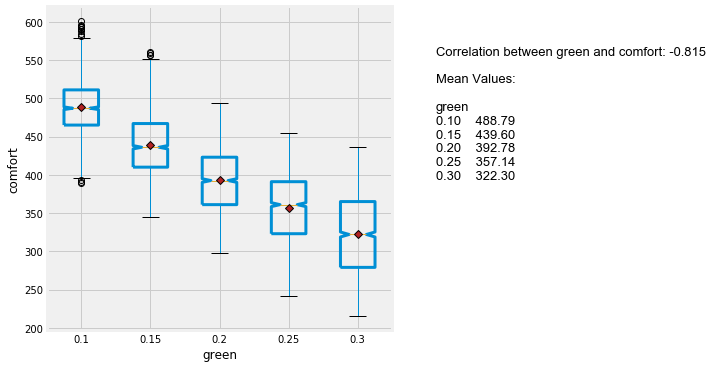

In [582]:
box_plotter('comfort')

In [583]:
bplot.get_figure().savefig("comfort_green.png", facecolor='white')

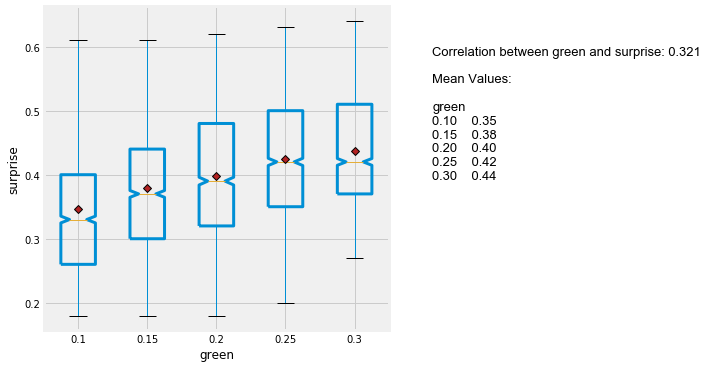

In [584]:
box_plotter('surprise')

In [585]:
bplot.get_figure().savefig("surprise_green.png", facecolor='white')

# DATA TRANSFORMATION

In [586]:
# FORMAT DATA FOR CLUSTERING TO DETERMINE TRENDS FOR EACH SCORING METHOD AT EACH DENSITY
# CREATE A DATAFRAME WITH ALL THREE SCORES, OUTPUTS AS MIN/MAX VALUES, AND REAL-WORLD INPUTS
# CLUSTER BEST PERFORMING OBSERVATIONS TO DISTILL TRENDS

drop_cols = ['grid_0', 'grid_1', 'grid_2', 'grid_3', 'grid_4', 'grid_5', 'park_attr_0', 
             'park_attr_1', 'park_attr_2', 'bar_bldg', 'courtyard', 'extrusion', 'industrial', 
             'infill', 'small_mid', 'street_area', 'iteration', 'towers', 'energy', 'view', 'dist', 
            'den_multi', 'green', 'park_attr_str', 'street_width']

data_drop = data.drop(drop_cols, axis=1)


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(data_drop)
base_score = [x.sum() for x in X_scaled]
X_exp = ((X_scaled*10)**3)
exp_score = [x.sum() for x in X_exp]
X_log = np.log((X_scaled*10)+1)
log_score = [x.sum() for x in X_log]


drop_cols = ['iteration', 'grid_0', 'grid_1', 'grid_2', 'grid_3', 'grid_4', 'grid_5', 'park_attr_0', 
             'park_attr_1', 'park_attr_2', 'bar_bldg', 'courtyard', 'extrusion', 'industrial', 
             'infill', 'small_mid', 'street_area', 'towers', 'energy', 'view', 
             'comfort', 'daylighting', 'surprise']

df1 = data.drop(drop_cols, axis=1)
df2 = pd.DataFrame(X_scaled, columns=['comfort', 'daylighting', 'surprise'])
data_new = pd.concat([df1, df2], axis=1, join='inner')
data_new['base_score'] = base_score
data_new['exp_score'] = exp_score
data_new['log_score'] = log_score

In [587]:
# ISOLATE TOP SCORES PER APPROACH PER DENSITY 
Den_S_exp = data_new[data_new.den_multi == 0.8].sort_values(by='exp_score', ascending=False).head(100).drop(['base_score', 'log_score'], axis=1)
Den_S_log = data_new[data_new.den_multi == 0.8].sort_values(by='log_score', ascending=False).head(100).drop(['base_score', 'exp_score'], axis=1)
Den_M_exp = data_new[data_new.den_multi == 1].sort_values(by='exp_score', ascending=False).head(100).drop(['base_score', 'log_score'], axis=1)
Den_M_log = data_new[data_new.den_multi == 1].sort_values(by='log_score', ascending=False).head(100).drop(['base_score', 'exp_score'], axis=1)
Den_L_exp = data_new[data_new.den_multi == 1.2].sort_values(by='exp_score', ascending=False).head(100).drop(['base_score', 'log_score'], axis=1)
Den_L_log = data_new[data_new.den_multi == 1.2].sort_values(by='log_score', ascending=False).head(100).drop(['base_score', 'exp_score'], axis=1)

In [588]:
len(data_new.log_score.unique())

8316

# LASSO

In [589]:
# GOAL IS TO CREATE PREDICTIONS FOR EACH DENSITY FOR EACH APPROACH (EXP VS. LOG)
metric = exp_score
name = 'exp_score'
density = 0.8

# DROP OUTPUT COLUMNS THAT WON'T EXIST IN PREDICTION DATASET 
drop_cols = ['daylighting', 'energy', 'comfort', 'surprise', 'iteration', 'bar_bldg', 'courtyard', 
             'extrusion', 'industrial', 'infill', 'small_mid', 'towers', 'street_area']

df = data.iloc[:, :].drop(drop_cols, axis=1)
df[name] = metric
df = df[df.den_multi == density]     # CREATE DENSITY-BASED SUBSET

y = df[name]
X = df.drop(name, axis=1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1)
y_null = np.zeros_like(y_test, dtype=float)
y_null.fill(y_test.mean())
y_null
print('Baseline RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_null)))

Baseline RMSE:  251.28764399031667


In [590]:
# K-FOLDS
kf = model_selection.KFold(n_splits=5, shuffle=True)
rmse_values = []
scores = []
n = 0

for train_index, test_index in kf.split(X, y):
    reg = linear_model.Lasso(alpha = 0.15)
    reg.fit(X.iloc[train_index], y.iloc[train_index])
    
    rmse_values.append(np.sqrt(metrics.mean_squared_error(y.iloc[test_index], reg.predict(X.iloc[test_index]))))
    scores.append(reg.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('RMSE: {}'.format(rmse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))

print('Mean of RMSE for all folds: {}'.format(np.mean(rmse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))



Model 1
RMSE: 108.40318743583556
R2: 0.8266114167784975

Model 2
RMSE: 114.53739509251223
R2: 0.8260840737572678

Model 3
RMSE: 91.81566346653048
R2: 0.8264862200750721

Model 4
RMSE: 103.21156989333727
R2: 0.8268073516616278

Model 5
RMSE: 102.83345321149599
R2: 0.8267761981238055

Mean of RMSE for all folds: 104.16025381994231
Mean of R2 for all folds: 0.8265530520792541


In [591]:
from sklearn import linear_model
reg = linear_model.Lasso(alpha = 0.1)
reg.fit([[0, 0], [1, 1]], [0, 1])
# Lasso(alpha=0.1, copy_X=True, fit_intercept=True, max_iter=1000,
#    normalize=False, positive=False, precompute=False, random_state=None,
#    selection='cyclic', tol=0.0001, warm_start=False)
reg.predict([[1, 1]])
#array([ 0.8])


array([0.8])

# LINEAR REGRESSION

### TEST EACH APPROACH

In [592]:
results = []

In [593]:
# GOAL IS TO CREATE PREDICTIONS FOR EACH DENSITY FOR EACH APPROACH (EXP VS. LOG)
metric = log_score
name = 'log_score'
density = 1.2

# DROP OUTPUT COLUMNS THAT WON'T EXIST IN PREDICTION DATASET 
drop_cols = ['daylighting', 'energy', 'comfort', 'surprise', 'iteration', 'bar_bldg', 'courtyard', 
             'extrusion', 'industrial', 'infill', 'small_mid', 'towers', 'street_area']

df = data.iloc[:, :].drop(drop_cols, axis=1)
df[name] = metric
df = df[df.den_multi == density]     # CREATE DENSITY-BASED SUBSET

y = df[name]
X = df.drop(name, axis=1)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, random_state=1)
y_null = np.zeros_like(y_test, dtype=float)
y_null.fill(y_test.mean())
y_null
print('Baseline RMSE: ', np.sqrt(metrics.mean_squared_error(y_test, y_null)))

Baseline RMSE:  0.6368592063006635


In [594]:
# K-FOLDS
kf = model_selection.KFold(n_splits=5, shuffle=True)
rmse_values = []
scores = []
n = 0

for train_index, test_index in kf.split(X, y):
    lr = LinearRegression().fit(X.iloc[train_index], y.iloc[train_index])
    
    rmse_values.append(np.sqrt(metrics.mean_squared_error(y.iloc[test_index], lr.predict(X.iloc[test_index]))))
    scores.append(lr.score(X, y))
    
    n += 1
    
    print('Model {}'.format(n))
    print('RMSE: {}'.format(rmse_values[n-1]))
    print('R2: {}\n'.format(scores[n-1]))

print('Mean of RMSE for all folds: {}'.format(np.mean(rmse_values)))
print('Mean of R2 for all folds: {}'.format(np.mean(scores)))

results.append({'name': name, 'density': density, 'RMSE': format(np.mean(rmse_values)), 'R2': format(np.mean(scores))})          

Model 1
RMSE: 0.28763580307728376
R2: 0.7747956781547594

Model 2
RMSE: 0.30325942482976437
R2: 0.7749504834080262

Model 3
RMSE: 0.30439359887672723
R2: 0.7749464434682044

Model 4
RMSE: 0.3036036224369997
R2: 0.7748557964308997

Model 5
RMSE: 0.29845032586384346
R2: 0.7748721333050743

Mean of RMSE for all folds: 0.2994685550169237
Mean of R2 for all folds: 0.7748841069533928


In [595]:
results

[{'R2': '0.7748841069533928',
  'RMSE': '0.2994685550169237',
  'density': 1.2,
  'name': 'log_score'}]

### CREATE LINEAR MODEL FOR EACH APPROACH

In [596]:
# DROP OUTPUT COLUMNS THAT WON'T EXIST IN PREDICTION DATASET 
drop_cols = ['daylighting', 'energy', 'view', 'comfort', 'surprise', 'iteration', 'bar_bldg', 'courtyard', 
             'extrusion', 'industrial', 'infill', 'small_mid', 'towers', 'street_area']

df = data.iloc[:, :].drop(drop_cols, axis=1)
df['exp_score'] = exp_score
df['log_score'] = log_score

In [597]:
scaler = MinMaxScaler()

# LOW DENSITY EXP
df_low = df[df.den_multi == 0.8] 
y = df_low['exp_score']
X = df_low.drop(['exp_score', 'log_score'], axis=1)
X_scaled = scaler.fit_transform(X)
lr_S_exp = LinearRegression().fit(X, y)

# LOW DENSITY LOG
y = df_low['log_score']
X = df_low.drop(['exp_score', 'log_score'], axis=1)
X_scaled = scaler.fit_transform(X)
lr_S_log = LinearRegression().fit(X, y)

# MID DENSITY EXP
df_mid = df[df.den_multi == 1] 
y = df_mid['exp_score']
X = df_mid.drop(['exp_score', 'log_score'], axis=1)
X_scaled = scaler.fit_transform(X)
lr_M_exp = LinearRegression().fit(X, y)

# MID DENSITY LOG
y = df_mid['log_score']
X = df_mid.drop(['exp_score', 'log_score'], axis=1)
X_scaled = scaler.fit_transform(X)
lr_M_log = LinearRegression().fit(X, y)

# HIGH DENSITY EXP
df_high = df[df.den_multi == 1.2] 
y = df_high['exp_score']
X = df_high.drop(['exp_score', 'log_score'], axis=1)
X_scaled = scaler.fit_transform(X)
lr_L_exp = LinearRegression().fit(X, y)

# HIGH DENSITY LOG
y = df_high['log_score']
X = df_high.drop(['exp_score', 'log_score'], axis=1)
X_scaled = scaler.fit_transform(X)
lr_L_log = LinearRegression().fit(X, y)

### MAKE PREDICTIONS

In [598]:
# PREDICT ITERATIONS MOST LIKELY TO ACHIEVE HIGH SCORE FOR EACH APPROACH
# CREATE ONE BIG LIST THAT CAN BE EXPORTED TO A CSV AND READ INTO GRASSHOPPER

num_pred = 50
predictions = []

# LOW DENSITY EXP
X = data_pred[data_pred.den_multi == 0.8].drop('iteration', axis=1)
X_scaled = scaler.fit_transform(X)
pred = lr_S_exp.predict(X_scaled)
iterations = data_pred[data_pred.den_multi == 0.8].iteration
scores = pd.DataFrame(iterations)
scores['results'] = pred
best_bets = scores.sort_values(by='results', ascending=False).iteration[:num_pred].tolist()
for bet in best_bets:
    predictions.append(bet)

# LOW DENSITY LOG
X = data_pred[data_pred.den_multi == 0.8].drop('iteration', axis=1)
X_scaled = scaler.fit_transform(X)
pred = lr_S_log.predict(X_scaled)
iterations = data_pred[data_pred.den_multi == 0.8].iteration
scores = pd.DataFrame(iterations)
scores['results'] = pred
best_bets = scores.sort_values(by='results', ascending=False).iteration[:num_pred].tolist()
for bet in best_bets:
    predictions.append(bet)

# MID DENSITY EXP
X = data_pred[data_pred.den_multi == 1].drop('iteration', axis=1)
X_scaled = scaler.fit_transform(X)
pred = lr_M_exp.predict(X_scaled)
iterations = data_pred[data_pred.den_multi == 1].iteration
scores = pd.DataFrame(iterations)
scores['results'] = pred
best_bets = scores.sort_values(by='results', ascending=False).iteration[:num_pred].tolist()
for bet in best_bets:
    predictions.append(bet)

# MID DENSITY LOG
X = data_pred[data_pred.den_multi == 1].drop('iteration', axis=1)
X_scaled = scaler.fit_transform(X)
pred = lr_M_log.predict(X_scaled)
iterations = data_pred[data_pred.den_multi == 1].iteration
scores = pd.DataFrame(iterations)
scores['results'] = pred
best_bets = scores.sort_values(by='results', ascending=False).iteration[:num_pred].tolist()
for bet in best_bets:
    predictions.append(bet)

# HIGH DENSITY EXP
X = data_pred[data_pred.den_multi == 1.2].drop('iteration', axis=1)
X_scaled = scaler.fit_transform(X)
pred = lr_L_exp.predict(X_scaled)
iterations = data_pred[data_pred.den_multi == 1.2].iteration
scores = pd.DataFrame(iterations)
scores['results'] = pred
best_bets = scores.sort_values(by='results', ascending=False).iteration[:num_pred].tolist()
for bet in best_bets:
    predictions.append(bet)

# HIGH DENSITY LOG
X = data_pred[data_pred.den_multi == 1.2].drop('iteration', axis=1)
X_scaled = scaler.fit_transform(X)
pred = lr_L_log.predict(X_scaled)
iterations = data_pred[data_pred.den_multi == 1.2].iteration
scores = pd.DataFrame(iterations)
scores['results'] = pred
best_bets = scores.sort_values(by='results', ascending=False).iteration[:num_pred].tolist()
for bet in best_bets:
    predictions.append(bet)

In [599]:
# PREDICTIONS ARE THE ITERATIONS, NOT THE SCORES
final = list(set(predictions)) # kill duplicates
out_put = pd.DataFrame(final, columns=['iterations'])
out_put.to_csv('./CSV/predictions.csv')

PermissionError: [Errno 13] Permission denied: './CSV/predictions.csv'

# ANALYZE PREDICTIONS

In [ ]:
results = pd.read_csv('./CSV/results.csv')

In [ ]:
drop_results = ['name', 'out:Landmark View', 'out:Energy Efficiency', 'out:#Towers', 'out:#Extrusions', 'out:#Industrial', 
                'out:#Courtyards', 'out:#Bar Bldgs', 'out:#Small Mid', 'out:#Infill', 'out:GFA', 'out:Street Area']

results.drop(drop_results, axis=1, inplace=True)

In [ ]:
results.columns = ['iteration', 'surprise', 'daylighting', 'comfort']

In [ ]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(results.drop('iteration', axis=1))
X_exp = ((X_scaled*10)**3)
exp_score = [x.sum() for x in X_exp]
X_log = np.log((X_scaled*10)+1)
log_score = [x.sum() for x in X_log]

results['exp_score'] = exp_score
results['log_score'] = log_score

In [ ]:
results.sort_values(by='exp_score', ascending=False).head(20)

In [ ]:
data['exp_score'] = data_new.exp_score
data['log_score'] = data_new.log_score

In [ ]:
data_scores = data[['surprise', 'daylighting', 'comfort', 'exp_score', 'log_score']]

In [ ]:
data_scores.sort_values(by='exp_score', ascending=False).head(20)

In [ ]:
data_scores.log_score.value_counts()

# IMPORT AND FORMAT NEW DATA 

In [ ]:
# PURELY FOR VISUALIZATION

df = data_new.iloc[:, :]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(df)
k = 15
kmeans = cluster.KMeans(n_clusters=k)
kmeans.fit(X_scaled);
clusters = kmeans.labels_
df['cluster'] = clusters
cols = ['comfort', 'daylighting', 'surprise']
color = sns.diverging_palette(330, 250, n=7, s=99)
#color = sns.cubehelix_palette(light=1)
asdf = sns.pairplot(data_new, x_vars=cols, y_vars= cols, hue='cluster', palette=color,
                    plot_kws={'alpha': 0.2, 's':40});
asdf.fig.set_size_inches(22,16)

In [ ]:
scores = [score**.7 for score in exp_score]
cols = ['comfort', 'daylighting', 'surprise']

asdf = sns.pairplot(data_new[data_new.den_multi==0.8], x_vars=cols, y_vars=cols, kind='reg', 
             plot_kws={'line_kws':{'color':'red', 'linewidth':1}, 'scatter_kws': {'alpha': 0.1, 's':scores}});
asdf.fig.set_size_inches(20,16)

# K-MEANS

In [ ]:
# ARE WE NORMALIZING THE INPUT VALUES????

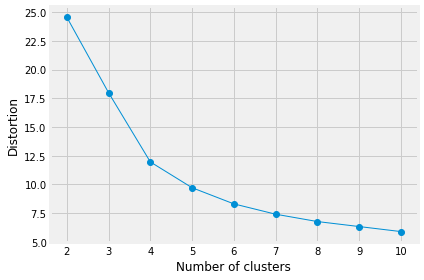

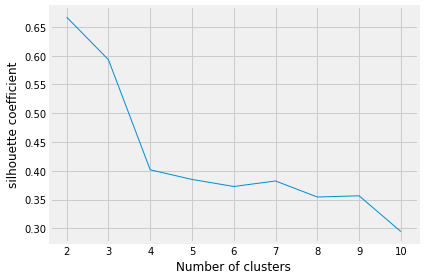

In [616]:
# NAME DENSITY AND SCORE METHOD TO CLUSTER
df = Den_S_exp

column_names = ['exp_score']
Values = df.drop(column_names, axis=1)

k_range = range(2,11)
distortions = []
scores = []
for i in k_range:
    km = cluster.KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=50, random_state=0)
    # SHOULDN'T SETTING RANDOM_STATE TO AN INTEGER ENSURE THAT THE RESULTS ARE THE SAME EACH TIME?
    km.fit(Values)
    distortions.append(km.inertia_)
    scores.append(metrics.silhouette_score(Values,km.labels_))
    
plt.plot(k_range, distortions, marker='o', linewidth=1)
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.tight_layout()
plt.show()

plt.plot(k_range, scores, linewidth=1)
plt.xlabel('Number of clusters')
plt.ylabel('silhouette coefficient')
plt.tight_layout()
plt.show()

In [618]:
k = 5
kmeans = cluster.KMeans(n_clusters=k, init='k-means++', n_init=10, max_iter=50, random_state=0)
kmeans.fit(Values)
clusters = kmeans.labels_
df['cluster'] = clusters
print(df.cluster.value_counts())

df.groupby('cluster').mean().T

2    29
0    27
4    18
3    13
1    13
Name: cluster, dtype: int64


cluster,0,1,2,3,4
dist,1.888889,4.000000,1.267241,3.000000,1.347222
den_multi,0.800000,0.800000,0.800000,0.800000,0.800000
green,0.216667,0.211538,0.174138,0.215385,0.266667
park_attr_str,0.711111,0.650000,0.686207,0.719231,0.700000
street_width,1.074074,0.984615,0.931034,1.069231,1.266667
comfort,0.488408,0.491908,0.598925,0.485315,0.397114
daylighting,0.363361,0.395940,0.268161,0.402886,0.452103
surprise,0.926731,0.916388,0.912294,0.933110,0.922705
exp_score,995.497093,1001.306671,1019.256808,1033.477725,961.676745


In [626]:
# This is just giving us the mean values. 

# center_cols = Values.columns
# centers = kmeans.cluster_centers_
# centers_df = pd.DataFrame(centers, columns=center_cols)
# centers_df

In [637]:
# FIND THE MEDOID
# CHOICE IS NOT CORRECT TO THE WAY THE 

choice = 2
centers = kmeans.cluster_centers_
center = centers[choice]
points = df[df.cluster==choice].drop(['cluster', 'exp_score'], axis=1)
errors = []

for point in points.values:
        dist = np.linalg.norm(point-center)
        errors.append(dist)

points['error'] = errors
points.sort_values(by='error').head()

,dist,den_multi,green,park_attr_str,street_width,comfort,daylighting,surprise,error
6692,1.25,0.8,0.10,0.80,0.9,0.636364,0.219020,0.891304,0.154799
4513,1.25,0.8,0.25,0.65,1.0,0.493506,0.323727,0.934783,0.163786
4978,1.25,0.8,0.10,0.80,0.8,0.646753,0.192843,0.891304,0.210507
6355,1.25,0.8,0.15,0.50,0.8,0.698701,0.236071,0.934783,0.253404
320,1.25,0.8,0.15,0.50,1.1,0.662338,0.254323,0.869565,0.264841


In [638]:
points.sort_values(by='error', ascending=False).head()

,dist,den_multi,green,park_attr_str,street_width,comfort,daylighting,surprise,error
814,1.0,0.8,0.20,0.95,1.2,0.563636,0.287944,0.891304,0.464858
3231,1.0,0.8,0.15,0.95,1.2,0.631169,0.275937,0.913043,0.463714
290,1.5,0.8,0.30,0.95,0.8,0.428571,0.365274,0.934783,0.442416
6788,1.5,0.8,0.30,0.95,0.8,0.428571,0.365274,0.934783,0.442416
3104,1.5,0.8,0.25,0.95,0.8,0.438961,0.293948,0.934783,0.416471


In [171]:
# y_km = km.fit_predict(Values)
# cluster_labels = np.unique(y_km)
# n_clusters = cluster_labels.shape[0]
# silhouette_vals = silhouette_samples(Values, y_km, metric='euclidean')
# y_ax_lower, y_ax_upper = 0,0
# y_ticks = []
# for i, c in enumerate(cluster_labels):
#     c_silhouette_vals = silhouette_vals(y_km == c)
#     c_silhouette_vals.sort()
#     y_ax_upper += len(c_silhouette_vals)
#     color = cm.jet(i / n_clusters)
#     plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, edgecolor='none', color=color)
#     yticks.append((y_ax_lower + y_ax_upper) / 2)
#     y_ax_lower += len(c_silhouette_vals)
# silhouette_avg = np.mean(silhouette_vals)
# plt.axvline(silhouette_avg, color='red', linestyle='--')
# plt.yticks(yticks, cluster_labels + 1)
# plt.ylabel('Cluster')
# plt.xlabel('Silhouette coefficient')
# plt.show()

In [317]:
# from sklearn.metrics import pairwise_distances_argmin_min
# closest, _ = pairwise_distances_argmin_min(km.cluster_centers_, Values)
# closest

In [318]:
drop_cols = ['bar_bldg', 'courtyard', 'industrial', 'small_mid', 'extrusion', 'infill', 'towers', 'view', 'energy']

### Den_S_exp

In [315]:
# CONCLUSION Den_S_exp: k=5
# Cluster O, Centroid is 6355 
# 93 Surprise, 70 Comfort, 24 Daylighting 
df[(df.cluster == 1) & (df.dist == 1.25) & (df.green == 0.15)].head(1)

,dist,den_multi,green,park_attr_str,street_width,comfort,daylighting,surprise,exp_score,cluster


In [319]:
data[data.iteration == 6355].drop(drop_cols, axis=1)

,dist,den_multi,green,iteration,park_attr_str,street_width,comfort,daylighting,street_area,surprise,grid_0,grid_1,grid_2,grid_3,grid_4,grid_5,park_attr_0,park_attr_1,park_attr_2
6355,1.25,0.8,0.15,6355,0.5,0.8,485,48.64,245881,0.61,0,0,0,0,0,1,0,0,1


### Den_S_log

In [173]:
# CONCLUSION Den_S_log: k=4
# Cluster O, Medoid is 4433 
# 74 Surprise, 45 Comfort, 46 Daylighting 
df[(df.cluster == 2) & (df.green == 0.25)].head()

,dist,den_multi,green,park_attr_str,street_width,comfort,daylighting,surprise,log_score,cluster
2384,4.0,0.8,0.25,0.80,0.9,0.514286,0.366955,0.782609,6.0,2
7163,4.0,0.8,0.25,0.65,1.4,0.415584,0.554275,0.673913,6.0,2
1481,4.0,0.8,0.25,0.65,1.4,0.423377,0.503122,0.826087,6.0,2
4433,4.0,0.8,0.25,0.50,1.2,0.451948,0.454611,0.739130,6.0,2


In [320]:
data[data.iteration == 4433].drop(drop_cols, axis=1)

,dist,den_multi,green,iteration,park_attr_str,street_width,comfort,daylighting,street_area,surprise,grid_0,grid_1,grid_2,grid_3,grid_4,grid_5,park_attr_0,park_attr_1,park_attr_2
4433,4.0,0.8,0.25,4433,0.5,1.2,390,57.74,311698,0.52,0,0,0,0,1,0,0,0,1


### Den_M_exp

In [299]:
# CONCLUSION Den_M_exp: k=4
# Cluster O, Medoid is 4365
# 89 Surprise, 66 Comfort, 28 Daylighting 
df[(df.cluster == 0) & (df.dist == 3.0) & (df.green == 0.15)]

,dist,den_multi,green,park_attr_str,street_width,comfort,daylighting,surprise,exp_score,cluster
4365,3.0,1.0,0.15,0.95,0.8,0.659740,0.277378,0.891304,1017.0,0
3732,3.0,1.0,0.15,0.95,0.8,0.659740,0.278098,0.891304,1017.0,0
3227,3.0,1.0,0.15,0.95,0.9,0.657143,0.292747,0.891304,1017.0,0


In [330]:
data[data.iteration == 4365].drop(drop_cols, axis=1)

,dist,den_multi,green,iteration,park_attr_str,street_width,comfort,daylighting,street_area,surprise,grid_0,grid_1,grid_2,grid_3,grid_4,grid_5,park_attr_0,park_attr_1,park_attr_2
4365,3.0,1.0,0.15,4365,0.95,0.8,470,50.36,210274,0.59,0,0,0,0,0,1,0,0,1


In [332]:
# data.iloc[4365, :]

In [325]:
# Cluster 1, Medoid is row 7820, iteration 7930
# 87 Surprise, 66 Daylighting, 35 Comfort
df[(df.cluster == 1) & (df.green == 0.3) & (df.dist == 1.25)]

,dist,den_multi,green,park_attr_str,street_width,comfort,daylighting,surprise,exp_score,cluster
391,1.25,1.0,0.3,0.65,1.1,0.319481,0.527378,0.956522,1054.0,1
3556,1.25,1.0,0.3,0.95,0.8,0.298701,0.471182,0.956522,1006.0,1
7820,1.25,1.0,0.3,0.65,1.0,0.353247,0.663305,0.869565,993.0,1
8328,1.25,1.0,0.3,0.50,1.3,0.457143,0.733189,0.782609,969.0,1
4516,1.25,1.0,0.3,0.50,1.2,0.410390,0.685639,0.804348,912.0,1


In [329]:
data.iloc[7820, :]

dist                  1.25
den_multi             1.00
green                 0.30
iteration          7930.00
park_attr_str         0.65
street_width          1.00
bar_bldg             36.00
courtyard            33.00
extrusion             0.00
industrial            1.00
infill                0.00
small_mid             0.00
towers                4.00
comfort             352.00
daylighting          66.43
energy                0.00
view                974.00
street_area      265899.00
surprise              0.58
grid_0                1.00
grid_1                0.00
grid_2                0.00
grid_3                0.00
grid_4                0.00
grid_5                0.00
park_attr_0           0.00
park_attr_1           0.00
park_attr_2           1.00
Name: 7820, dtype: float64

### Den_M_Log

In [611]:
# Cluster 1, Medoid is row 7820, iteration 7930
# 87 Surprise, 66 Daylighting, 35 Comfort
df[(df.cluster == 2) & (df.green == 0.2)]

,dist,den_multi,green,park_attr_str,street_width,comfort,daylighting,surprise,log_score,cluster
6702,2.0,1.0,0.2,0.5,1.4,0.631169,0.593420,0.630435,5.914409,2
726,1.5,1.0,0.2,0.8,1.4,0.561039,0.588617,0.673913,5.864447,2
3853,1.5,1.0,0.2,0.5,1.4,0.568831,0.549232,0.695652,5.844973,2
1910,2.0,1.0,0.2,0.8,1.4,0.545455,0.579251,0.673913,5.826894,2
5994,1.5,1.0,0.2,0.5,1.4,0.535065,0.576849,0.673913,5.807125,2


In [615]:
data[(data.iteration == 6702)].surprise


6702    0.47
Name: surprise, dtype: float64

### Den_L_exp

In [344]:
# Cluster 1, Medoid is row 7820, iteration 7930
# 87 Surprise, 66 Daylighting, 35 Comfort
df[(df.cluster == 0) & (df.green == 0.3) & (df.dist == 1.5) & (df.park_attr_str == 0.65)]

,dist,den_multi,green,park_attr_str,street_width,comfort,daylighting,surprise,exp_score,cluster
4519,1.5,1.2,0.3,0.65,1.3,0.470130,0.916667,0.717391,1243.0,0
3779,1.5,1.2,0.3,0.65,1.4,0.402597,0.737272,0.739130,870.0,0


In [346]:
data[(data.iteration == 4519)].drop(drop_cols, axis=1)

,dist,den_multi,green,iteration,park_attr_str,street_width,comfort,daylighting,street_area,surprise,grid_0,grid_1,grid_2,grid_3,grid_4,grid_5,park_attr_0,park_attr_1,park_attr_2
4519,1.5,1.2,0.3,4519,0.65,1.3,397,76.98,291118,0.51,0,1,0,0,0,0,0,0,1


### Den_L_log

In [603]:
# Cluster 2, 
# 87 Surprise, 66 Daylighting, 35 Comfort
df[(df.cluster == 2) & (df.green == 0.25) & (df.dist == 3.0)]

,dist,den_multi,green,park_attr_str,street_width,comfort,daylighting,surprise,log_score,cluster
4052,3.0,1.2,0.25,0.8,1.3,0.498701,0.699328,0.739130,5.995389,2
4427,3.0,1.2,0.25,0.8,1.2,0.511688,0.693564,0.695652,5.956408,2
800,3.0,1.2,0.25,0.8,0.9,0.503896,0.650817,0.739130,5.941419,2


In [604]:
data[(data.iteration == 4427)].drop(drop_cols, axis=1)

,dist,den_multi,green,park_attr_str,street_width,grid_0,grid_1,grid_2,grid_3,grid_4,grid_5,park_attr_0,park_attr_1,park_attr_2
4427,3.0,1.2,0.25,0.8,1.2,0,1,0,0,0,0,0,0,1


In [607]:
data[(data.iteration == 4427)].surprise


4427    0.5
Name: surprise, dtype: float64